The purpose of this notebook is to explore where a distributor of meat and dairy substitutes suitable for vegans might consider distributing to, or exploring as future sites of distribution, in the city of Toronto. This is done using k-means clustering and data supplied through the foursquare API and the Canadian census bureau.

Our first step is to import the libraries.

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium --yes
!conda install -c conda-forge geocoder --yes
#!conda install -c conda-forge dbfread --yes
!conda install -c conda-forge shapely --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [2]:
#Import more libraries.
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
import folium
import requests
from pandas.io.json import json_normalize
import json
import urllib
import geopy
from geopy import distance
import geocoder
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ast
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely as sh

Now we import the first of the data from the Canadian Census Bureau. This data will be geographic data for the Toronto area as well as statisitics on the population of the Toronto area.

In [3]:
#Get the population statistics.
toro = pd.read_csv('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv')

In [4]:

#Get the geography data.
 

# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:


url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"

params = { "id": "4def3f65-2a65-4a4f-83c4-b2a4aed72d46"}

response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))

package = json.loads(response.read())

print(package["result"])

# Get the data by passing the resource_id to the datastore_search endpoint

# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options

# For example, to retrieve the data content for the first resource in the datastore:

for idx, resource in enumerate(package["result"]["resources"]):

    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"] }
        r = urllib.request.urlopen(url, data=bytes(json.dumps(p), encoding="utf-8"))
        data = json.loads(r.read())
        tor_geo = pd.DataFrame(data["result"]["records"])
        break


{'license_title': 'Open Government Licence – Toronto', 'owner_unit': None, 'relationships_as_object': [], 'topics': 'Locations and mapping', 'owner_email': 'opendata@toronto.ca', 'excerpt': 'Boundaries of Toronto Neighbourhoods.', 'private': False, 'owner_division': 'Social Development, Finance & Administration', 'num_tags': 9, 'id': '4def3f65-2a65-4a4f-83c4-b2a4aed72d46', 'metadata_created': '2019-07-23T17:47:38.364157', 'refresh_rate': 'As available', 'title': 'Neighbourhoods', 'license_url': 'https://open.toronto.ca/open-data-license/', 'state': 'active', 'information_url': 'http://www.toronto.ca/demographics/neighbourhoods.htm', 'license_id': 'open-government-licence-toronto', 'type': 'dataset', 'resources': [{'cache_last_updated': None, 'package_id': '4def3f65-2a65-4a4f-83c4-b2a4aed72d46', 'datastore_active': True, 'id': 'a083c865-6d60-4d1d-b6c6-b0c8a85f9c15', 'size': None, 'format': 'GeoJSON', 'state': 'active', 'hash': '', 'description': '', 'is_preview': True, 'last_modified': 

In [5]:
#The data has commas to seperate numbers. We must remove those. We also must conver the geographic data
#from a string to a dictionary.


names = list(tor_geo['AREA_NAME'])
geo = list(tor_geo['geometry'])
new_names = []
new_geo = []
for i in names:
    i = i.translate(str.maketrans('','',')(1234567890'))
    new_names.append(i)
for i in geo:
    i = ast.literal_eval(i)
    new_geo.append(i)

print(len(new_geo), len(new_names), type(new_geo[1]))

100 100 <class 'dict'>


In [60]:
#We set the new columns as the fixed columns.
tor_geo['AREA_NAME'] = new_names
tor_geo['geometry'] = new_geo
tor_geo[tor_geo['AREA_NAME']=='Agincourt North ']
#tor_geo.geometry[0].get('coordinates')

,AREA_ATTR_ID,AREA_DESC,AREA_ID,AREA_LONG_CODE,AREA_NAME,AREA_SHORT_CODE,LATITUDE,LONGITUDE,OBJECTID,PARENT_AREA_ID,Shape__Area,Shape__Length,X,Y,_id,geometry
74,25926736,Agincourt North (129),25886428,129,Agincourt North,129,43.805441,-79.266712,16492689,49885,1.395145e+07,17159.740667,None,None,3435,"{'type': 'Polygon', 'coordinates': [[[-79.2421..."


We now move on to the next part of the data, the census data. Below we transform it to a usable form by setting the characteristic column to the index and transposing the data.

In [7]:
toro.set_index('Characteristic', inplace = True)
toro.head()

,_id,Category,Topic,Data Source,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
Characteristic,,,,,,,,,,,,,,,,,,,,,
Neighbourhood Number,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,NaN,129,128,20,95,42,...,37,7,137,64,60,94,100,97,27,31
TSNS2020 Designation,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
"Population, 2016",3,Population,Population and dwellings,Census Profile 98-316-X2016001,"2,731,571","29,113","23,757","12,054","30,526","27,695",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
"Population, 2011",4,Population,Population and dwellings,Census Profile 98-316-X2016001,"2,615,060","30,279","21,988","11,904","29,177","26,918",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
Population Change 2011-2016,5,Population,Population and dwellings,Census Profile 98-316-X2016001,4.50%,-3.90%,8.00%,1.30%,4.60%,2.90%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


In [62]:
tr_pop = toro.T

tr_pop.reset_index(inplace = True)
tr_pop.rename(columns={"index":'Neighbourhood'}, inplace = True)
tr_pop.head()


Characteristic,Neighbourhood,Neighbourhood Number,TSNS2020 Designation,"Population, 2016","Population, 2011",Population Change 2011-2016,Total private dwellings,Private dwellings occupied by usual residents,Population density per square kilometre,Land area in square kilometres,...,External migrants,Total - Mobility status 5 years ago - 25% sample data,Non-movers,Movers,Non-migrants,Migrants,Internal migrants,Intraprovincial migrants,Interprovincial migrants,External migrants
0,_id,1,2,3,4,5,6,7,8,9,...,2374,2375,2376,2377,2378,2379,2380,2381,2382,2383
1,Category,Neighbourhood Information,Neighbourhood Information,Population,Population,Population,Population,Population,Population,Population,...,Mobility,Mobility,Mobility,Mobility,Mobility,Mobility,Mobility,Mobility,Mobility,Mobility
2,Topic,Neighbourhood Information,Neighbourhood Information,Population and dwellings,Population and dwellings,Population and dwellings,Population and dwellings,Population and dwellings,Population and dwellings,Population and dwellings,...,Mobility status - Place of residence 1 year ago,Mobility status - Place of residence 5 years ago,Mobility status - Place of residence 5 years ago,Mobility status - Place of residence 5 years ago,Mobility status - Place of residence 5 years ago,Mobility status - Place of residence 5 years ago,Mobility status - Place of residence 5 years ago,Mobility status - Place of residence 5 years ago,Mobility status - Place of residence 5 years ago,Mobility status - Place of residence 5 years ago
3,Data Source,City of Toronto,City of Toronto,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,...,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001,Census Profile 98-316-X2016001
4,City of Toronto,NaN,NaN,"2,731,571","2,615,060",4.50%,"1,179,057","1,112,929","4,334",630.2,...,"59,945","2,556,120","1,516,110","1,040,015","639,060","400,950","184,120","141,135","42,985","216,835"


In [9]:
#Here the geogrphy data of interest is gathered.

nbhd_coords  =  tor_geo[['AREA_NAME', 'AREA_SHORT_CODE', 'AREA_LONG_CODE', 'LATITUDE', 'LONGITUDE', 'geometry']]
nbhd_coords.sort_values(by = 'AREA_NAME', inplace = True, axis = 0)
#nbhd_coords.set_index('AREA_NAME', inplace = True)
nbhd_coords['AREA_LONG_CODE'] = pd.to_numeric(nbhd_coords['AREA_LONG_CODE'])
nbhd_coords['AREA_SHORT_CODE'] = pd.to_numeric(nbhd_coords['AREA_SHORT_CODE'])
#nbhd_coords['AREA_NAME'] = nbhd_coords['AREA_NAME'].astype(str)
#tr_pop.reset_index(inplace = True)
#nbhd_coords.set_index('AREA_NAME', inplace = True)
nbhd_coords.head()
nbhd_coords.dtypes


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.

AREA_NAME           object
AREA_SHORT_CODE      int64
AREA_LONG_CODE       int64
LATITUDE           float64
LONGITUDE          float64
geometry            object
dtype: object

Below we join the desired geographic data with the census data.

In [10]:
#tr_pop.drop(['_id','Category','Topic',"Data Source", 'City of Toronto'], axis = 0, inplace = True)
tr_pop.drop([0,1,2,3,4], inplace = True)

nbhd_coords['AREA_SHORT_CODE'].astype('float64')
tr_pop['Neighbourhood Number'] = pd.to_numeric(tr_pop['Neighbourhood Number'])
#tr_pop_co = tr_pop.join(nbhd_coords, lsuffix = 'Neighbourhood Number', rsuffix='AREA_SHORT_CODE', how = 'inner', sort = True)
#tr_pop_co = tr_pop.set_index('Neighbourhood').join(nbhd_coords.set_index('AREA_NAME'), how = 'inner', on = 'Neighbourhood' sort = True)
tr_pop_co = pd.merge(tr_pop, nbhd_coords, left_on = 'Neighbourhood Number', right_on='AREA_SHORT_CODE', how = 'inner')

#
tr_pop_co.shape
#tr_pop_co.dtypes
#

(100, 2390)

In [196]:
#This function was used to search for catagories where the column name did not exactly match 
#that given by the census bureau.
median = [i for i in tr_pop_co.columns if 'Males' in i]
print(median)


['Total - Population aged 15 years and over by Labour force status (Males) - 25% sample data', '  In the labour force (Males)', '    Employed (Males)', '    Unemployed (Males)', '  Not in the labour force (Males)', 'Participation rate (Males)', 'Employment rate (Males)', 'Unemployment rate (Males)']


There are a number of categories of interest for how one might segment the neighborhoods in Toronto. I have chosen to use some data which is not directly present such as the total fraction of each gender present. Below I have written some functions that will sum columns and make fractions for ht enew dataframe to be used for the clustering.

In [11]:
def remove_com(frm, col):
    item = list(frm[col])
    new_item = []
    for i in item:
        i = i.translate(str.maketrans('','',','))
        new_item.append(i)
    frm[col] = new_item

def make_nums(nums, col, olist):
    for j in col:
        out_vec = np.array(nums[j])
        out_vec = [k.translate(str.maketrans('','',',')) for k in out_vec]
        out_vec = list(map(float, out_vec))
        out_vec = np.array(out_vec)
        olist.append(out_vec)
        
def make_sum(col, out):
    init = np.array(col[0])
    for i in col[1:]:
        i = np.array(i)
        init = init + i
    for i in init:
        out.append(i)




def fracs(x1, x2, out):
    c = 0 
    while c < len(x1):
        frac = x1[c]/x2[c]
        out.append(frac)
        c = c + 1
#        print(c)

  

In [15]:
#tr_key_fac will be the dataframe intially used in the clustering.

tr_key_fac = tr_pop_co[['Neighbourhood','Population density per square kilometre', 'Employment rate','Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
                       ]]

for k in tr_key_fac.columns:
    remove_com(tr_key_fac, k)
tr_key_fac['Population density per square kilometre'] = pd.to_numeric(tr_key_fac['Population density per square kilometre'])
tr_key_fac['Employment rate'] = pd.to_numeric(tr_key_fac['Employment rate'])
tr_key_fac['Employment rate'] = tr_key_fac['Employment rate']* 1/100
tr_key_fac['Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)'] = pd.to_numeric(tr_key_fac['Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)'])
tr_key_fac['Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)'] = tr_key_fac['Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)'] *1/100
tr_key_fac.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

,Neighbourhood,Population density per square kilometre,Employment rate,"Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)"
0,Agincourt North,3929,0.500,0.213
1,Agincourt South-Malvern West,3034,0.532,0.226
2,Alderwood,2435,0.624,0.082
3,Annex,10863,0.658,0.183
4,Banbury-Don Mills,2775,0.556,0.137


The previous functions are used to make the needed columns.

In [63]:


cols = list(tr_pop_co.columns)
tpop = [k.translate(str.maketrans('','',',')) for k in np.array(tr_pop_co['Population, 2016'])]

list_fem = [i for i in cols if 'Female:' in i]
list_male = [i for i in cols if 'Male:' in i]
list_young = [i for i in cols if ('Male:' in i or 'Female:' in i) and ('15' in i or '20' in i or '25' in i or '30' in i)]
list_high_income = ['    In the sixth decile', '    In the seventh decile', '    In the eighth decile', '    In the ninth decile', '    In the top decile']
#income_list = []
#income_frac = []

cit_list = []
cit_frac = []

high_income_list = []
high_income_num = []
high_income_frac = []

aged_15_34_list = []
aged_15_34_nums = []
frac_15_34 = []

f_list = []
m_list = []
male = []
fems = []
fem_frac =[]
male_frac = []
a_nums = []
w_nums = []
white_frac = []
asian_frac = []


tpop = pd.to_numeric(tpop)

make_nums(tr_pop_co, ['  Canadian citizens'], cit_list)
fracs(cit_list[0], tpop, cit_frac)

make_nums(tr_pop_co, list_young, aged_15_34_list)
make_sum(aged_15_34_list, aged_15_34_nums)
fracs(aged_15_34_nums, tpop, frac_15_34)

make_nums(tr_pop_co, list_high_income, high_income_list)
make_sum(high_income_list, high_income_num)
fracs(high_income_num, tpop, high_income_frac)



make_nums(tr_pop_co, list_fem, f_list)
make_sum(f_list, fems)
fracs(fems, tpop, fem_frac)


make_nums(tr_pop_co, list_male, m_list)
make_sum(m_list, male)
fracs(male, tpop, male_frac)



make_nums(tr_pop_co, [' Asian origins'], a_nums)
make_nums(tr_pop_co, [' European origins'], w_nums)
fracs(a_nums[0], tpop, asian_frac)
fracs(w_nums[0], tpop, white_frac)
#print(frac_15_34)

In [16]:

tr_key_fac['Fraction High Income'] = high_income_frac
tr_key_fac['Fraction Canadian Citizen'] = cit_frac
tr_key_fac['Fraction Female'] = fem_frac
tr_key_fac['Fraction Male'] = male_frac
tr_key_fac['Fraction 15 to 34'] = frac_15_34
tr_key_fac['Fraction Asian'] = asian_frac
tr_key_fac['Fraction European'] = white_frac


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [17]:
#We exclude the cityt of Toronto data.
tr_key_fac = tr_key_fac[tr_key_fac['Neighbourhood'] != 'City of Toronto']
tr_key_fac.head()

,Neighbourhood,Population density per square kilometre,Employment rate,"Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",Fraction High Income,Fraction Canadian Citizen,Fraction Female,Fraction Male,Fraction 15 to 34,Fraction Asian,Fraction European
0,Agincourt North,3929,0.500,0.213,0.353966,0.808917,0.522104,0.477965,0.257102,0.834850,0.104936
1,Agincourt South-Malvern West,3034,0.532,0.226,0.348739,0.800396,0.511218,0.488698,0.296334,0.755777,0.158690
2,Alderwood,2435,0.624,0.082,0.603949,0.947818,0.509374,0.489049,0.231044,0.170483,0.757840
3,Annex,10863,0.658,0.183,0.542980,0.836991,0.530859,0.470255,0.372797,0.212442,0.689740
4,Banbury-Don Mills,2775,0.556,0.137,0.586929,0.870374,0.537823,0.461997,0.206174,0.434194,0.485106


In [64]:
tr_pop_co.head()

,Neighbourhood,Neighbourhood Number,TSNS2020 Designation,"Population, 2016","Population, 2011",Population Change 2011-2016,Total private dwellings,Private dwellings occupied by usual residents,Population density per square kilometre,Land area in square kilometres,...,Internal migrants,Intraprovincial migrants,Interprovincial migrants,External migrants,AREA_NAME,AREA_SHORT_CODE,AREA_LONG_CODE,LATITUDE,LONGITUDE,geometry
0,Agincourt North,129,No Designation,"29,113","30,279",-3.90%,"9,371","9,120","3,929",7.41,...,880,735,135,"2,280",Agincourt North,129,129,43.805441,-79.266712,"{'type': 'Polygon', 'coordinates': [[[-79.2421..."
1,Agincourt South-Malvern West,128,No Designation,"23,757","21,988",8.00%,"8,535","8,136","3,034",7.83,...,980,760,220,"2,170",Agincourt South-Malvern West,128,128,43.788658,-79.265612,"{'type': 'Polygon', 'coordinates': [[[-79.2549..."
2,Alderwood,20,No Designation,"12,054","11,904",1.30%,"4,732","4,616","2,435",4.95,...,680,615,70,245,Alderwood,20,20,43.604937,-79.541611,"{'type': 'Polygon', 'coordinates': [[[-79.5486..."
3,Annex,95,No Designation,"30,526","29,177",4.60%,"18,109","15,934","10,863",2.81,...,"3,930","2,630","1,310","2,460",Annex,95,95,43.671585,-79.404001,"{'type': 'Polygon', 'coordinates': [[[-79.3941..."
4,Banbury-Don Mills,42,No Designation,"27,695","26,918",2.90%,"12,473","12,124","2,775",9.98,...,"1,405","1,190",220,"1,735",Banbury-Don Mills,42,42,43.737657,-79.349718,"{'type': 'Polygon', 'coordinates': [[[-79.3305..."


Here we use the foursquare API to gather data on vegan and vegetarian locations. We will get the top fifty for the Greater Toronto Area.

In [18]:
# The code was removed by Watson Studio for sharing.

In [19]:
latitude=43.714672
longitude= -79.457108
categoryID = '4bf58dd8d48988d1d3941735'
radius = 8000

veg_venues_list=[]

       #print(name)
            
        # create the API request URL
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryID, radius, LIMIT)
            
        # make the GET request
veg_results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
if len(veg_results) == 0:
    veg_venues_list.append('NaN')
else:
    veg_venues_list.append([(
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in veg_results])


In [20]:
tr_key_fac.insert(2, 'Latitude', tr_pop_co.LATITUDE)
tr_key_fac.insert(3, 'Longitude', tr_pop_co.LONGITUDE)

The function below will assign a venue to its closest neighborhood. I have choosen to use distance as a metric rather than the actual location as it is more like to represent the customer base.


In [21]:

neigh_ven = []
def find_dist(dfrom, dfrom_lat, dfrom_lon, dto, dto_lat, dto_lon, pos, out):
    for k in dfrom:
        d = 100
        n = ''
        center_point_tuple = (k[dfrom_lat],k[dfrom_lon])
        for i in dto.iterrows():
            test_point_tuple = (i[1][dto_lat], i[1][dto_lon])
            dist = distance.geodesic(center_point_tuple, test_point_tuple).km
            #dist = np.sqrt(((i[1][2] - k[dfrom_lat])**2) + ((i[1][3] - k[dfrom_lon])**2))
            #print(np.sqrt(((i[1][2] - i[1][4])**2) + ((i[1][2] - i[1][5])**2)))
            #print(k[0], i[1][1])
            if d > dist:
                #print(d)
                d = dist
                n = i[1][pos]
         
        out.append([n,k[0],d])

find_dist(veg_venues_list[0], 1, 2, tr_key_fac, 2, 3, 0, neigh_ven)
print(len(neigh_ven))

50


In [87]:
## This was a first attempt at grouping the restaurants. I decided on using a distance method instead.

hood = []
def find_hood(inlist, frame, names, f_col, olist):
    for i in inlist:
        p = Point(i[1],i[2])
        for k in frame.iterrows():
            ind = 0
            #pol = Polygon([tuple(i[0]) for i in list(zip(k[1][len(frame.columns)-1].get('coordinates')))][0])
            pol = Polygon([tuple(i) for i in list(k[1][len(frame.columns)-1].get('coordinates'))][0])
            #print(p.within(pol))
            #print(len(pol), type(pol[0]), len(pol[0][0]), pol[0][0])
            if p.within(pol) == True:
                #print('F')
                olist.append([k[1][0], i[0]])
            ind += 1
            #print(list(polygon)[0][0], len(list(polygon)))

            
find_hood(veg_venues_list[0], tr_pop_co, 'Neighbourhood', 'geometry', hood)
#find_hood_2(veg_venues_list[0], tr_pop_co, 'Neighbourhood', 'geometry', hood)
def prnt(frame):
    point = Point(veg_venues_list[0][0][1], veg_venues_list[0][0][2])
#
    pol = Polygon([tuple(i[0]) for i in list(zip(frame[frame.columns[len(frame.columns) -1]][0].get('coordinates')[0]))])
    

('By Chloe', 43.724992, -79.455054, 'Vegetarian / Vegan Restaurant') 0


In [23]:
#Find the neighborhoods with venues close by.

close_vens =  [i for i in neigh_ven if i[2]<.65]
print(close_vens)

[['University', 'Fresh on Bloor', 0.5075376126449125], ['Mount Pleasant West', 'Fresh', 0.370279966844253], ['Annex', 'Live Organic Food Bar', 0.4431065484748261], ['Trinity-Bellwoods', 'Fresh', 0.5744210466604025], ['Trinity-Bellwoods', 'Virtuous Pie', 0.5300757476835554], ['South Parkdale', 'South Indian Dosa Mahal', 0.612151602143769], ['Trinity-Bellwoods', 'Burgers n’ Fries Forever', 0.46557120890855425], ['Bay Street Corridor', "Karine's", 0.5861175456961562], ['University', 'Veda Healthy Indian Takeout', 0.5759990838103832], ['Palmerston-Little Italy', 'YamChops', 0.4410045427455572], ['Bay Street Corridor', 'Freshii', 0.2852877686960402], ['Yonge-Eglinton', 'Kupfert & Kim', 0.5410261562268501], ['Little Portugal', 'The Goods', 0.5431855537324763], ['Little Portugal', 'E.L. Ruddy Co. Cafe', 0.29951142031135675]]


In [24]:
#print(neigh_ven)
neigh_ven_zip = list(zip(*close_vens))

print(neigh_ven_zip, len(neigh_ven_zip[0]))

[('University', 'Mount Pleasant West', 'Annex', 'Trinity-Bellwoods', 'Trinity-Bellwoods', 'South Parkdale', 'Trinity-Bellwoods', 'Bay Street Corridor', 'University', 'Palmerston-Little Italy', 'Bay Street Corridor', 'Yonge-Eglinton', 'Little Portugal', 'Little Portugal'), ('Fresh on Bloor', 'Fresh', 'Live Organic Food Bar', 'Fresh', 'Virtuous Pie', 'South Indian Dosa Mahal', 'Burgers n’ Fries Forever', "Karine's", 'Veda Healthy Indian Takeout', 'YamChops', 'Freshii', 'Kupfert & Kim', 'The Goods', 'E.L. Ruddy Co. Cafe'), (0.5075376126449125, 0.370279966844253, 0.4431065484748261, 0.5744210466604025, 0.5300757476835554, 0.612151602143769, 0.46557120890855425, 0.5861175456961562, 0.5759990838103832, 0.4410045427455572, 0.2852877686960402, 0.5410261562268501, 0.5431855537324763, 0.29951142031135675)] 14


In [25]:
#Make a new dataframe with locations per neighborhood.

ven_df = pd.DataFrame(neigh_ven_zip)
ven_df = ven_df.T
ven_df.columns = ['Neighbourhood', 'Venue', 'Distance']
ven_df.drop('Distance', axis = 1, inplace = True)
ven_grp = ven_df.groupby('Neighbourhood').count()
ven_grp.columns = ['Venue Count']
ven_grp

,Venue Count
Neighbourhood,
Annex,1
Bay Street Corridor,2
Little Portugal,2
Mount Pleasant West,1
Palmerston-Little Italy,1
South Parkdale,1
Trinity-Bellwoods,3
University,2
Yonge-Eglinton,1


In [26]:
#Merge with the previous data for clustering.
veg_tr_key = pd.merge(tr_key_fac, ven_grp, left_on = 'Neighbourhood', right_index = True, how = 'left')
veg_tr_key.fillna(value = 0, inplace = True, axis = 1)

for i in veg_tr_key.iloc[0:, 4:7].columns:
    veg_tr_key[i] = pd.to_numeric(veg_tr_key[i])
veg_tr_key.head()

,Neighbourhood,Population density per square kilometre,Latitude,Longitude,Employment rate,"Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",Fraction High Income,Fraction Canadian Citizen,Fraction Female,Fraction Male,Fraction 15 to 34,Fraction Asian,Fraction European,Venue Count
0,Agincourt North,3929,43.805441,-79.266712,0.500,0.213,0.353966,0.808917,0.522104,0.477965,0.257102,0.834850,0.104936,0.0
1,Agincourt South-Malvern West,3034,43.788658,-79.265612,0.532,0.226,0.348739,0.800396,0.511218,0.488698,0.296334,0.755777,0.158690,0.0
2,Alderwood,2435,43.604937,-79.541611,0.624,0.082,0.603949,0.947818,0.509374,0.489049,0.231044,0.170483,0.757840,0.0
3,Annex,10863,43.671585,-79.404001,0.658,0.183,0.542980,0.836991,0.530859,0.470255,0.372797,0.212442,0.689740,1.0
4,Banbury-Don Mills,2775,43.737657,-79.349718,0.556,0.137,0.586929,0.870374,0.537823,0.461997,0.206174,0.434194,0.485106,0.0


In [65]:
veg_tr_key.drop(['Latitude', 'Longitude'], 1)
print('dropped')

dropped


We now use the elbow method to determine an optimal k for the clustering method. 

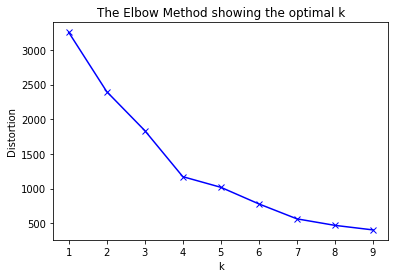

In [29]:
# create new plot and data
plt.plot()
#X = veg_tr_key.drop(['Neighbourhood', 'Population density per square kilometre'], 1)
X = veg_tr_key.drop(['Neighbourhood'],1)


colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']



# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


The above graph indicates the the precision of the clustering suggests a k of four but is not as decisive as might be hoped. We will try four.

In [28]:
# set number of clusters
kclusters = 4


#tr_clustering = tr_key_fac.drop(['Neighbourhood', 'Population density per square kilometre'], 1)
veg_clustering = veg_tr_key.drop(['Neighbourhood', 'Population density per square kilometre'], 1)
# run k-means clustering
kmeans_tr = KMeans(n_clusters=kclusters, random_state=0).fit(veg_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_tr.labels_[0:10] 

array([0, 0, 1, 3, 1, 1, 2, 0, 0, 1], dtype=int32)

In [ ]:
#tr_key_fac.drop('Cluster Labels', axis = 1, inplace = True)
#tr_key_fac.insert(0, 'Cluster Labels', kmeans_tr.labels_)
#tr_key_fac.insert(2, 'Latitude', tr_pop_co.LATITUDE)
#tr_key_fac.insert(3, 'Longitude', tr_pop_co.LONGITUDE)
#tr_key_fac.head()

In [30]:
#veg_tr_key.drop('Cluster Labels', axis = 1, inplace = True)
veg_tr_key.insert(0, 'Cluster Labels', kmeans_tr.labels_)
veg_tr_key.drop('Latitude', axis = 1, inplace = True)
veg_tr_key.insert(1, 'Latitude', tr_pop_co.LATITUDE)
veg_tr_key.drop('Longitude', axis = 1, inplace = True)
veg_tr_key.insert(2, 'Longitude', tr_pop_co.LONGITUDE)
veg_tr_key.head()

,Cluster Labels,Latitude,Longitude,Neighbourhood,Population density per square kilometre,Employment rate,"Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",Fraction High Income,Fraction Canadian Citizen,Fraction Female,Fraction Male,Fraction 15 to 34,Fraction Asian,Fraction European,Venue Count
0,0,43.805441,-79.266712,Agincourt North,3929,0.500,0.213,0.353966,0.808917,0.522104,0.477965,0.257102,0.834850,0.104936,0.0
1,0,43.788658,-79.265612,Agincourt South-Malvern West,3034,0.532,0.226,0.348739,0.800396,0.511218,0.488698,0.296334,0.755777,0.158690,0.0
2,1,43.604937,-79.541611,Alderwood,2435,0.624,0.082,0.603949,0.947818,0.509374,0.489049,0.231044,0.170483,0.757840,0.0
3,3,43.671585,-79.404001,Annex,10863,0.658,0.183,0.542980,0.836991,0.530859,0.470255,0.372797,0.212442,0.689740,1.0
4,1,43.737657,-79.349718,Banbury-Don Mills,2775,0.556,0.137,0.586929,0.870374,0.537823,0.461997,0.206174,0.434194,0.485106,0.0


In [31]:
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[43.70011, -79.4163], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(veg_tr_key['Latitude'], veg_tr_key['Longitude'], veg_tr_key['Neighbourhood'], veg_tr_key['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [32]:
#Here we see if any clusters have distinctly high densities of vegan and vegetarian restaurants.

for i in range(len(list(veg_tr_key['Cluster Labels'].unique()))):
    print(i, veg_tr_key[veg_tr_key['Cluster Labels'] == i].shape, veg_tr_key[veg_tr_key['Cluster Labels'] == i]['Venue Count'].sum(), 
           veg_tr_key[veg_tr_key['Cluster Labels'] == i]['Venue Count'].sum()/veg_tr_key[veg_tr_key['Cluster Labels'] == i].shape[0])

0 (36, 15) 0.0 0.0
1 (55, 15) 0.0 0.0
2 (4, 15) 9.0 2.25
3 (5, 15) 5.0 1.0


We examine the cluster labels below.

In [33]:
veg_tr_key[veg_tr_key['Cluster Labels'] == 0].describe()


,Cluster Labels,Latitude,Longitude,Population density per square kilometre,Employment rate,"Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",Fraction High Income,Fraction Canadian Citizen,Fraction Female,Fraction Male,Fraction 15 to 34,Fraction Asian,Fraction European,Venue Count
count,36.0,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.0
mean,0.0,43.755642,-79.354717,6339.388889,0.538333,0.256028,0.345844,0.802213,0.519315,0.480447,0.286618,0.562403,0.278237,0.0
std,0.0,0.042760,0.114305,7286.881894,0.035307,0.075905,0.090110,0.050653,0.014445,0.014451,0.035438,0.149727,0.104577,0.0
min,0.0,43.659992,-79.596356,1117.000000,0.473000,0.095000,0.171736,0.696851,0.469782,0.457275,0.229208,0.228426,0.050994,0.0
25%,0.0,43.725412,-79.428524,3212.500000,0.511500,0.209000,0.296152,0.761394,0.512060,0.470894,0.263538,0.461075,0.212419,0.0
50%,0.0,43.766238,-79.332564,4819.500000,0.536500,0.244000,0.351338,0.804316,0.520262,0.480176,0.282559,0.554423,0.277812,0.0
75%,0.0,43.786118,-79.272935,6322.000000,0.563750,0.275250,0.406501,0.837430,0.528299,0.487395,0.300737,0.647749,0.349367,0.0
max,0.0,43.821201,-79.176676,44321.000000,0.604000,0.455000,0.532411,0.911369,0.541981,0.530755,0.379987,0.893798,0.512674,0.0


In [34]:
veg_tr_key[veg_tr_key['Cluster Labels'] == 1].describe()

,Cluster Labels,Latitude,Longitude,Population density per square kilometre,Employment rate,"Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",Fraction High Income,Fraction Canadian Citizen,Fraction Female,Fraction Male,Fraction 15 to 34,Fraction Asian,Fraction European,Venue Count
count,55.0,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.0
mean,1.0,43.686274,-79.421190,5770.981818,0.621182,0.159564,0.551444,0.883017,0.515944,0.483601,0.263844,0.233549,0.645146,0.0
std,0.0,0.040904,0.084902,3574.055361,0.060412,0.064613,0.139051,0.047797,0.022464,0.022348,0.068914,0.083466,0.115514,0.0
min,1.0,43.592362,-79.573432,1040.000000,0.478000,0.062000,0.279003,0.789087,0.431825,0.448647,0.194085,0.115596,0.421020,0.0
25%,1.0,43.662850,-79.490064,3605.000000,0.586500,0.111500,0.429926,0.845600,0.509480,0.470670,0.227467,0.173819,0.553274,0.0
50%,1.0,43.687859,-79.420227,4685.000000,0.618000,0.152000,0.542147,0.887681,0.519102,0.481253,0.255336,0.212739,0.652603,0.0
75%,1.0,43.713140,-79.366090,7399.000000,0.656500,0.186500,0.652230,0.926383,0.526729,0.489230,0.272662,0.270515,0.748673,0.0
max,1.0,43.782376,-79.150843,23044.000000,0.827000,0.319000,0.806805,0.959437,0.552258,0.568126,0.545795,0.483663,0.844114,0.0


In [35]:
veg_tr_key[veg_tr_key['Cluster Labels'] == 2].describe()

,Cluster Labels,Latitude,Longitude,Population density per square kilometre,Employment rate,"Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",Fraction High Income,Fraction Canadian Citizen,Fraction Female,Fraction Male,Fraction 15 to 34,Fraction Asian,Fraction European,Venue Count
count,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00
mean,2.0,43.654432,-79.408141,10480.250000,0.649500,0.226000,0.436516,0.780493,0.511059,0.489976,0.453973,0.332473,0.578441,2.25
std,0.0,0.006840,0.019105,3891.343159,0.068724,0.106374,0.038856,0.100385,0.010930,0.011325,0.086666,0.169249,0.152830,0.50
min,2.0,43.647536,-79.430323,5395.000000,0.562000,0.147000,0.401597,0.666163,0.503745,0.473505,0.364520,0.210489,0.362833,2.00
25%,2.0,43.649516,-79.419087,8526.250000,0.628750,0.153750,0.403574,0.711269,0.504042,0.487134,0.414335,0.251288,0.524026,2.00
50%,2.0,43.653844,-79.408261,11214.500000,0.653000,0.190000,0.436065,0.793771,0.506746,0.494087,0.439606,0.268195,0.627276,2.00
75%,2.0,43.658760,-79.397315,13168.500000,0.673750,0.262250,0.469006,0.862995,0.513763,0.496929,0.479243,0.349380,0.681691,2.25
max,2.0,43.662506,-79.385721,14097.000000,0.730000,0.377000,0.472336,0.868265,0.526999,0.498225,0.572160,0.583014,0.696382,3.00


In [36]:
veg_tr_key[veg_tr_key['Cluster Labels'] == 3].describe()

,Cluster Labels,Latitude,Longitude,Population density per square kilometre,Employment rate,"Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",Fraction High Income,Fraction Canadian Citizen,Fraction Female,Fraction Male,Fraction 15 to 34,Fraction Asian,Fraction European,Venue Count
count,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0
mean,3.0,43.675313,-79.411739,11835.600000,0.674600,0.190800,0.502457,0.844703,0.525635,0.474394,0.366054,0.250238,0.660157,1.0
std,0.0,0.029483,0.017820,5821.123757,0.021078,0.072799,0.144888,0.045775,0.018872,0.019835,0.037007,0.059555,0.108405,0.0
min,3.0,43.636700,-79.439338,7162.000000,0.647000,0.120000,0.273926,0.800796,0.498650,0.449457,0.308031,0.181180,0.490183,1.0
25%,3.0,43.659157,-79.418409,9583.000000,0.658000,0.138000,0.499022,0.802325,0.516780,0.466701,0.366849,0.212442,0.630016,1.0
50%,3.0,43.671585,-79.404001,9601.000000,0.682000,0.183000,0.521481,0.836991,0.530859,0.470255,0.371413,0.244986,0.689740,1.0
75%,3.0,43.704435,-79.403590,10863.000000,0.691000,0.208000,0.542980,0.882204,0.533130,0.482786,0.372797,0.277328,0.715495,1.0
max,3.0,43.704689,-79.393360,21969.000000,0.695000,0.305000,0.674875,0.901201,0.548756,0.502769,0.411182,0.335256,0.775351,1.0


In [51]:
#Look at the characteristics of the cluster with the highest density.

veg_tr_key[veg_tr_key['Cluster Labels'] == 2]

,Cluster Labels,Latitude,Longitude,Neighbourhood,Population density per square kilometre,Employment rate,"Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)",Fraction High Income,Fraction Canadian Citizen,Fraction Female,Fraction Male,Fraction 15 to 34,Fraction Asian,Fraction European,Venue Count
6,2,43.657511,-79.385721,Bay Street Corridor,14097,0.562,0.377,0.401597,0.666163,0.526999,0.473505,0.572160,0.583014,0.362833,2.0
31,2,43.647536,-79.430323,Little Portugal,12859,0.730,0.156,0.467896,0.861238,0.509352,0.491677,0.430940,0.210489,0.696382,2.0
79,2,43.650176,-79.415342,Trinity-Bellwoods,9570,0.651,0.147,0.472336,0.868265,0.503745,0.496497,0.364520,0.271503,0.676794,3.0
80,2,43.662506,-79.401180,University,5395,0.655,0.224,0.404233,0.726305,0.504141,0.498225,0.448271,0.264888,0.577757,2.0


As expected the neighborhood with the largest amount of venues skews towards a large young population. It should be noted that the neighborhood has a high population density as well as not being predominantly lower income. The neighborhood featuring the second highest number of venues also has a large young population and relatively high income. We will see which neighborhood in cluster 2 has the most grocery stores.

In [55]:
latitude=43.714672
longitude= -79.457108
categoryID = '4bf58dd8d48988d118951735'
radius = 1500

groc_list=[]

       #print(name)
            
        # create the API request URL
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryID, radius, LIMIT)
            
        # make the GET request
veg_results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
if len(veg_results) == 0:
    veg_venues_list.append('NaN')
else:
    groc_list.append([(
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in veg_results])


In [56]:
gstores = []
find_dist(groc_list[0], 1, 2, veg_tr_key[veg_tr_key['Cluster Labels'] == 2], 1, 2, 3, gstores)

In [66]:
gstores_zip = list(zip(*gstores))



In [59]:
gs_df = pd.DataFrame(gstores_zip)
gs_df = gs_df.T
gs_df.columns = ['Neighbourhood', 'Venue', 'Distance']
gs_df.drop('Distance', axis = 1, inplace = True)
gs_grp = gs_df.groupby('Neighbourhood').count()
gs_grp.columns = ['Venue Count']
gs_grp

,Venue Count
Neighbourhood,
University,10


it is clear that the majority of grocery stores in the area surround the 'University' neighborhood. This suggests that this neighborhood might be a good place to advertise or distribute meat and dairy substitute products.